<a href="https://colab.research.google.com/github/sheikmohdimran/Experiments_2020/blob/master/Vision/AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai2 -q

     |████████████████████████████████| 194kB 5.7MB/s 


In [2]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
from fastai2.vision.all import *

In [4]:
path = untar_data(URLs.PETS)/'images'

In [5]:
pets_multi = DataBlock(blocks=(ImageBlock, ImageBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 #get_y=get_image_files,#Pipeline([RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'), lambda label: [label]]),
                 item_tfms=RandomResizedCrop(460, min_scale=0.75),
                 batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [6]:
#pets_multi.summary(untar_data(URLs.PETS)/"images",  bs=32)

In [9]:
dls = pets_multi.dataloaders(path,  bs=32)

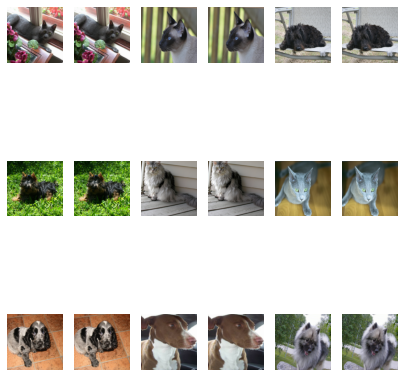

In [10]:
dls.show_batch(max_n=9, figsize=(7,8))

In [11]:
t = dls.one_batch()
x1=t[0][0]
x1.unsqueeze_(0).shape

torch.Size([1, 3, 224, 224])

In [13]:
# https://alanbertl.com/autoencoder-with-fast-ai/
class UpSample(nn.Module):
    def __init__(self,feat_in,feat_out,out_shape=None,scale=2):
        super().__init__()
        self.conv = nn.Conv2d(feat_in,feat_out,kernel_size=(3,3),stride=1,padding=1)
        self.out_shape,self.scale = out_shape,scale
        
    
    def forward(self,x):
        return self.conv(
            nn.functional.interpolate(
                x,size=self.out_shape,scale_factor=self.scale,mode='bilinear',align_corners=True))

def get_upSamp(feat_in,feat_out, out_shape=None, scale=2, act='relu'):
    upSamp = UpSample(feat_in,feat_out,out_shape=out_shape,scale=scale).cuda()
    layer = nn.Sequential(upSamp)
    
    if act == 'relu':
        act_f = nn.ReLU(inplace=True).cuda()
        bn = nn.BatchNorm2d(feat_out).cuda()
        layer.add_module('ReLU',act_f)
        layer.add_module('BN',bn)
    elif act == 'sig':
        act_f = nn.Sigmoid()
        layer.add_module('Sigmoid',act_f)
    return layer

def add_layer(m,feat_in,feat_out,name,out_shape=None,scale=2,act='relu'):
    upSamp = get_upSamp(feat_in,feat_out,out_shape=out_shape,scale=scale,act=act)
    m.add_module(name,upSamp)


In [14]:
code_sz = 32
#t = dls.one_batch()
#x1=t[0][0]
#x1.unsqueeze_(0).shape

m = resnet34(pretrained = True).cuda()
m = nn.Sequential(*list(m.children())[:-3])


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [15]:
t[0].shape

torch.Size([32, 3, 224, 224])

In [16]:
m(t[0]).size()

torch.Size([32, 256, 14, 14])

In [17]:
add_layer(m,256,128,'Upsample1')
add_layer(m,128,64,'Upsample2')
add_layer(m,64,32,'Upsample3',out_shape=(112,112),scale=None)
add_layer(m,32,3,'Upsample4')

In [18]:
m(t[0]).size()

torch.Size([32, 3, 224, 224])

In [19]:
learn = Learner(dls,m,loss_func=F.mse_loss)

In [20]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,0.215913,0.165938,01:58


epoch,train_loss,valid_loss,time
0,0.126951,0.110661,01:59
1,0.116531,0.102070,01:59
2,0.105649,0.084361,02:00
3,0.095236,0.080572,02:01
4,0.090030,0.080723,02:01
5,0.085013,0.077051,02:01
6,0.078674,0.064917,02:02
7,0.075073,0.061842,02:01
8,0.074784,0.060055,02:01
9,0.071081,0.058627,02:02


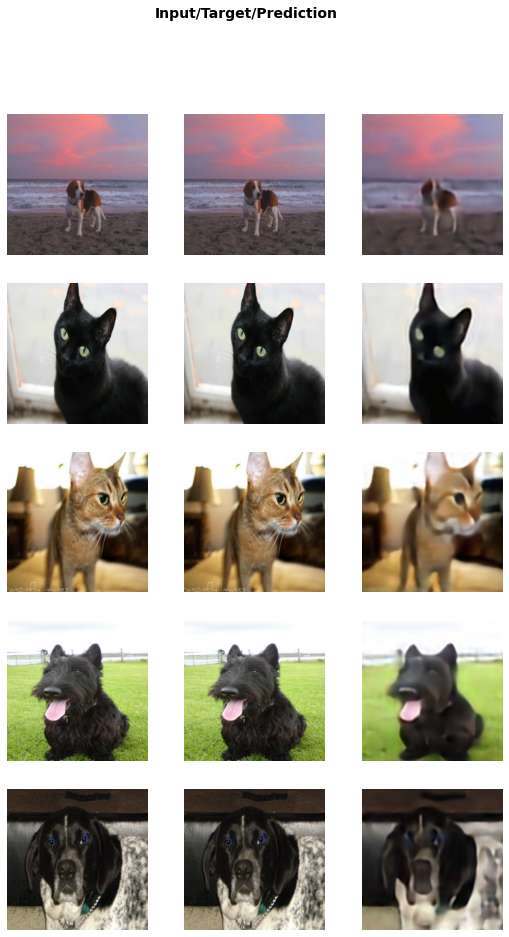

In [21]:
learn.show_results()

In [22]:
!wget -q https://modernfarmer.com/wp-content/uploads/2014/12/mule.jpg

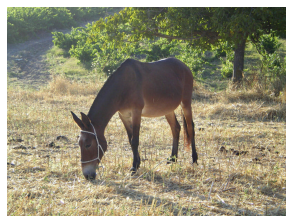

In [23]:
img = PILImage.create('mule.jpg')
img.show()

In [24]:
test_files = (['./mule.jpg'])
test_dl = learn.dls.test_dl(test_files)

In [25]:
output_mask = learn.predict('mule.jpg')

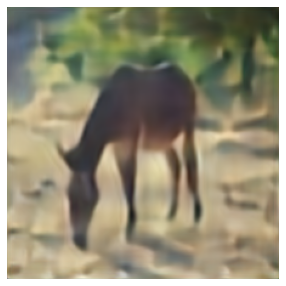

In [26]:
output_mask[0].show(figsize=(5,5))

In [27]:
learn.summary()

Sequential (Input shape: ['32 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          32 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 32 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               32 x 64 x 56 x 56    36,864     True      
________________________________________________________________
BatchNorm2d          32 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 32 x 64 x 56 x 56    0          False     
_________________________________________________